# Process ERA5 to ACCESS-ESM1-5 grid and time period

This will be used to verify and bias-correct the ACCESS model.

In [114]:
# from dask.distributed import Client,LocalCluster
# from dask_jobqueue import PBSCluster

In [115]:
# # One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

# walltime = '00:30:00'
# cores = 24
# memory = str(4 * cores) + 'GB'

# cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
#                      job_extra_directives=['-q normal',
#                                            '-P w42',
#                                            '-l ncpus='+str(cores),
#                                            '-l mem='+str(memory),
#                                            '-l storage=gdata/w42+gdata/rt52+gdata/fs38'],
#                      local_directory='$TMPDIR',
#                      job_directives_skip=["select"])
#                      # python=os.environ["DASK_PYTHON"])

In [116]:
# cluster.scale(jobs=1)
# client = Client(cluster)

In [117]:
# client#.restart()

In [1]:
import xarray as xr
import xesmf as xe

import matplotlib.pyplot as plt

Model template grid

In [2]:
template = xr.open_mfdataset(
    "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/tas/gn/latest/tas_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_20000101-20141231.nc"
)

In [3]:
template = template["tas"].isel(time=0).sel(lon=slice(133, 155), lat=slice(-45, -10))
template = template.drop("time").drop("height").compute()

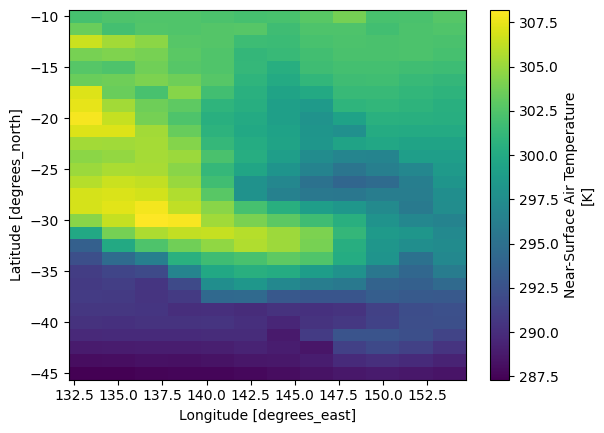

In [60]:
template.plot()

Model time period

In [4]:
model_times = slice("1950", "2014")

### ERA5 data. Already have some variables daily.

In [5]:
def preprocess(ds):
    ds = ds.rename({"longitude": "lon", "latitude": "lat"})
    return ds.sel(lon=slice(133, 155), lat=slice(-8, -45))

In [6]:
def regrid(files, out_ds):
    ds = xr.open_mfdataset(files, preprocess=preprocess)
    ds = ds.sel(time=model_times)
    regridder = xe.Regridder(ds, out_ds, "bilinear")
    return regridder(ds, keep_attrs=True)

tas / 2t

In [102]:
model_tas = regrid("/g/data/w42/dr6273/work/data/era5/2t/daily/*.nc", template).compute()

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/dataarray.py:857: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


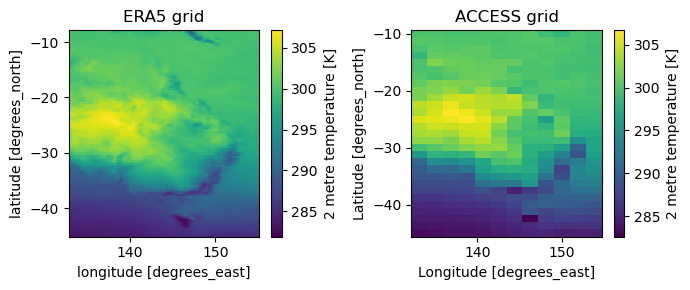

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

xr.open_mfdataset("/g/data/w42/dr6273/work/data/era5/2t/daily/*.nc", preprocess=preprocess)["t2m"].isel(time=0).plot(ax=ax[0])
ax[0].set_title("ERA5 grid")

model_tas["t2m"].isel(time=0).plot(ax=ax[1])
ax[1].set_title("ACCESS grid")

plt.tight_layout()

In [107]:
model_tas.nbytes / 1024 ** 3

0.02666928619146347

In [108]:
model_tas.to_netcdf(
    "/g/data/w42/dr6273/work/data/era5/regridded/CMIP6/2t_era5_ACCESS-ESM1-5_1959-2014_NEM.nc"
)

Precip

In [110]:
%%time
model_pr = regrid("/g/data/w42/dr6273/work/data/era5/mtpr/daily/*.nc", template).compute()

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/dataarray.py:857: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


CPU times: user 4.2 s, sys: 25.9 s, total: 30.1 s
Wall time: 2min 12s


In [112]:
model_pr.nbytes / 1024 ** 3

0.02666928619146347

In [113]:
model_pr.to_netcdf(
    "/g/data/w42/dr6273/work/data/era5/regridded/CMIP6/mtpr_era5_ACCESS-ESM1-5_1959-2014_NEM.nc"
)

Tasmax

In [7]:
%%time
model_tasmax = regrid("/g/data/w42/dr6273/work/data/era5/2tmax/daily/*.nc", template).compute()

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/dataarray.py:857: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


CPU times: user 7.02 s, sys: 29.6 s, total: 36.6 s
Wall time: 3min 18s


In [112]:
model_tasmax.nbytes / 1024 ** 3

0.02666928619146347

In [8]:
model_tasmax.to_netcdf(
    "/g/data/w42/dr6273/work/data/era5/regridded/CMIP6/tasmax_era5_ACCESS-ESM1-5_1959-2014_NEM.nc"
)

rsds

In [9]:
%%time
model_rsds = regrid("/g/data/w42/dr6273/work/data/era5/msdwswrf/daily/*.nc", template).compute()

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/dataarray.py:857: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


CPU times: user 2.62 s, sys: 34.4 s, total: 37 s
Wall time: 3min 26s


In [10]:
model_rsds.nbytes / 1024 ** 3

0.02666928619146347

In [11]:
model_rsds.to_netcdf(
    "/g/data/w42/dr6273/work/data/era5/regridded/CMIP6/rsds_era5_ACCESS-ESM1-5_1959-2014_NEM.nc"
)

sfcWind

In [12]:
%%time
model_sfcWind = regrid("/g/data/w42/dr6273/work/data/era5/10w/daily/*.nc", template).compute()

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/dataarray.py:857: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


CPU times: user 2.63 s, sys: 34.9 s, total: 37.5 s
Wall time: 3min 40s


In [13]:
model_sfcWind.nbytes / 1024 ** 3

0.02666928619146347

In [14]:
model_sfcWind.to_netcdf(
    "/g/data/w42/dr6273/work/data/era5/regridded/CMIP6/sfcWind_era5_ACCESS-ESM1-5_1959-2014_NEM.nc"
)